<a href="https://colab.research.google.com/github/Sabeerawa05/Datasets-Practices/blob/main/poverty_pred_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import os
from imutils import paths
import random
import h5py
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import progressbar
import matplotlib.pyplot as plt

In [ ]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
                             "exists and cannot be overwritten. Manually delete "
                             "the file before continuing.", outputPath)

        # open the HDF5 database for writing and create two datasets:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,
                                           dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0], 4),
                                             dtype="float")

        # store the buffer size, then initialize the buffer itself
        # along with the index into the datasets
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str)
        labelSet = self.db.create_dataset("label_names",
                                          (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):
        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

In [ ]:
#data_path = '/content/drive/MyDrive/archive'

In [ ]:
data_path = 'satelitte_images'
train_hdf5 = 'satelitte_images/hdf5/train.hdf5'
val_hdf5 =  'satelitte_images/hdf5/val.hdf5'
test_hdf5 =  'satelitte_images/hdf5/test.hdf5'

In [ ]:
imagePaths = list(paths.list_images(data_path))

In [ ]:
imagePaths[:5]

['satelitte_images\\ethiopia_archive\\images\\10.001614493498009_38.21928274979602_10.0165864149_38.2492265926.png',
 'satelitte_images\\ethiopia_archive\\images\\10.006878190821991_37.647636949694025_9.99190626942_37.6925527139.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.16824952909403_10.0245110384_39.2131652933.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.18322145049602_10.0245110384_39.2131652933.png',
 'satelitte_images\\ethiopia_archive\\images\\10.009539116998008_39.2131652933_10.0245110384_39.2131652933.png']

In [ ]:
len(imagePaths)

56160

In [ ]:
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
imagePaths[:5]

['satelitte_images\\ethiopia_archive\\images\\8.103335065686016_38.193701130798004_8.13327890849_38.2086730522.png',
 'satelitte_images\\malawi_archive\\images\\-10.739254078598007_33.55225392140199_-10.754226_33.537282.png',
 'satelitte_images\\malawi_archive\\images\\-15.781865235794024_35.142495764205975_-15.826781_35.09758.png',
 'satelitte_images\\malawi_archive\\images\\-15.735151842803985_35.136095078598004_-15.705208_35.151067.png',
 'satelitte_images\\ethiopia_archive\\images\\ethiopia_Images\\8.563866629893985_39.223355202794025_8.53392278709_39.268270967.png']

In [ ]:
imageLabels = [p.split(os.path.sep)[1] for p in imagePaths]

In [ ]:
len(imageLabels)

56160

In [ ]:
le = LabelEncoder()
imageLabels = le.fit_transform(imageLabels)

In [ ]:
classNames = [pt.split(os.path.sep)[1] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

In [ ]:
classNames

['Mali_archive', 'ethiopia_archive', 'malawi_archive', 'nigeria_archive']

In [ ]:
np.unique(imageLabels)

array([0, 1, 2, 3], dtype=int64)

In [ ]:
imageLabels = to_categorical(imageLabels, len(classNames))

In [ ]:
imageLabels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
# perform stratified sampling from the training set to build the
 # testing split from the training data
split = train_test_split(imagePaths, imageLabels,
                         test_size=0.10, stratify=imageLabels,  random_state=42)

(trainPaths, testPaths, trainLabels, testLabels) = split

# perform another stratified sampling, this time to build the
# validation data
split = train_test_split(trainPaths, trainLabels,
                         test_size=0.15, stratify=trainLabels,random_state=42)

(trainPaths, valPaths, trainLabels, valLabels) = split

In [ ]:
# construct a list pairing the training, validation, and testing
# image paths along with their corresponding labels and output HDF5
# files
datasets = [("train", trainPaths, trainLabels, train_hdf5),
            ("val", valPaths, valLabels, val_hdf5),
            ("test", testPaths, testLabels, test_hdf5)]

In [ ]:
# loop over the dataset tuples
for (dType, paths, labels, outputPath) in datasets:
    # create HDF5 writer
    print("[INFO] building {}...".format(outputPath))
    writer = HDF5DatasetWriter((len(paths), 256, 256, 3), outputPath)

    # initialize the progress bar
    widgets = ["Building Dataset: ", progressbar.Percentage(), " ",
               progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(paths),
                                   widgets=widgets).start()

    # loop over the image paths
    for (i, (path, label)) in enumerate(zip(paths, labels)):
        # load the image and process it
        image = cv2.imread(path)
        image = image.astype('float')/255.0

        # add the image and label # to the HDF5 dataset
        writer.add([image], [label])
        pbar.update(i)

    # close the HDF5 writer
    pbar.finish()
    writer.close()


In [ ]:
def read_hdf5(dir):
    db = h5py.File(dir, mode='r')

    return db

In [ ]:
train_data = read_hdf5(train_hdf5)

In [ ]:
list(train_data.keys())

In [ ]:
train_data['images'].shape

In [ ]:
train_data['labels'].shape

In [ ]:
val_data = read_hdf5(val_hdf5)

In [ ]:
test_data = read_hdf5(test_hdf5)

In [ ]:
train_data['images'][0:32].shape


In [ ]:
class HDF5DatasetGenerator:

    def __init__(self, dbPath, batchSize):

        # store the batch size, preprocessors, and data augmentor,
        # whether or not the labels should be binarized, along with
        # the total number of classes
        self.batchSize = batchSize


        # open the HDF5 database for reading and determine the total
        # number of entries in the database
        self.db = h5py.File(dbPath, mode='r')
        self.numImages = self.db["labels"].shape[0]


    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have
        # reach the desired number of epochs
        while epochs < passes:
            # loop over the HDF5 dataset
            for i in np.arange(0, self.numImages, self.batchSize):
                # extract the images and labels from the HDF dataset
                images = self.db["images"][i: i + self.batchSize]
                labels = self.db["labels"][i: i + self.batchSize]

                # yield a tuple of images and labels
                yield (images, labels)

    def close(self):
        # close the database
        self.db.close()

In [ ]:
# initialize the training and validation dataset generators
trainGen = HDF5DatasetGenerator(train_hdf5, 8)
valGen = HDF5DatasetGenerator(val_hdf5, 8)
testGen = HDF5DatasetGenerator(test_hdf5, 8)

### RESNET MODEL - 1

In [ ]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(256, 256, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2048, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classNames), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False



[INFO] preparing model...


In [ ]:
# compile the model
epochs = 200
lr = 1e-4
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [ ]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)]

In [ ]:
mcp = ModelCheckpoint(filepath='satelitte_models/weights/resnetmodel_weight.h5', save_weights_only=True,
                     monitor="val_loss",  verbose=1)

In [ ]:
csv_log = CSVLogger('satelitte_models/train_log/resnet_training.csv', separator=',',append=True)

In [ ]:
trainGen.numImages

42962

In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit(x = trainGen.generator(),
              validation_data=valGen.generator(),
              steps_per_epoch=trainGen.numImages // 8,
              validation_steps=valGen.numImages // 8,
              epochs=epochs, callbacks=[es, mcp, csv_log], verbose=1)

[INFO] training network...
Epoch 1/200
5370/5370 [==============================] - 684s 126ms/step - loss: 1.4504 - accuracy: 0.2894 - val_loss: 1.3188 - val_accuracy: 0.3576

Epoch 00001: saving model to satelitte_models/weights\resnetmodel_weight.h5
Epoch 2/200
5370/5370 [==============================] - 733s 136ms/step - loss: 1.3284 - accuracy: 0.3566 - val_loss: 1.3075 - val_accuracy: 0.3739

Epoch 00002: saving model to satelitte_models/weights\resnetmodel_weight.h5
Epoch 3/200
5370/5370 [==============================] - 774s 144ms/step - loss: 1.3128 - accuracy: 0.3633 - val_loss: 1.3104 - val_accuracy: 0.3663

Epoch 00003: saving model to satelitte_models/weights\resnetmodel_weight.h5
Epoch 4/200
5370/5370 [==============================] - 730s 136ms/step - loss: 1.3057 - accuracy: 0.3655 - val_loss: 1.3230 - val_accuracy: 0.3634

Epoch 00004: saving model to satelitte_models/weights\resnetmodel_weight.h5
Epoch 5/200
5370/5370 [==============================] - 705s 131ms/s

In [ ]:
model.load_weights('satelitte_models/weights/resnetmodel_weight.h5')

In [ ]:
mcp = ModelCheckpoint(filepath='satelitte_models/weights/resnetmodel_weight.h5', save_weights_only=True,
                     monitor="val_loss",  verbose=1)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

In [ ]:
csv_log = CSVLogger('satelitte_models/train_log/resnet_training.csv', separator=',',append=True)

In [ ]:
import pandas as pd

In [ ]:
history = pd.read_csv('satelitte_models/train_log/resnet_training.csv')

In [ ]:
history

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.316131,1.377736,0.357577,1.318803
1,1,0.357615,1.323699,0.373944,1.307464
2,2,0.364716,1.310695,0.366288,1.310398
3,3,0.366415,1.304842,0.363384,1.322955
4,4,0.369046,1.305263,0.379884,1.298449
5,5,0.372352,1.299313,0.375264,1.307386
6,6,0.371351,1.297134,0.372756,1.303775
7,7,0.373004,1.296518,0.364308,1.327159
8,8,0.373493,1.293504,0.378432,1.297606
9,9,0.377543,1.291904,0.378828,1.298951


In [ ]:
ResNetHist = history.to_dict('list')

In [ ]:
# saving model
model.save('satelitte_models/resnet_model_satelitte.h5')

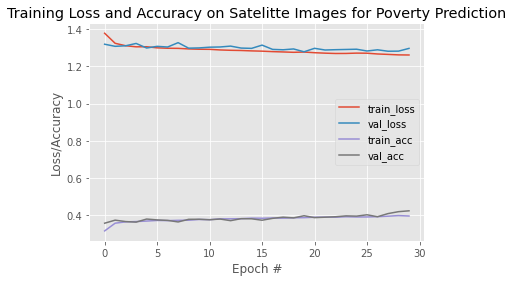

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(ResNetHist["loss"], label="train_loss")
plt.plot(ResNetHist["val_loss"], label="val_loss")
plt.plot(ResNetHist["accuracy"], label="train_acc")
plt.plot(ResNetHist["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Satelitte Images for Poverty Prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
testGen.numImages

In [ ]:
num_pred = (testGen.numImages // 8) * 8
num_pred

5616

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
num_pred = (testGen.numImages // 8) * 8
predictions = model.predict(testGen.generator(passes=1),
                                      steps=testGen.numImages // 8)
y_pred = predictions.argmax(axis=-1)
y_true = test_data['labels'][...].argmax(axis=-1)[:num_pred]
print(classification_report(y_true, y_pred,
                            target_names=classNames))
#predictions = model.predict(testX, batch_size=32)
#print(classification_report(testY.argmax(axis=1),
                            #predictions.argmax(axis=1), target_names=classNames))

[INFO] evaluating network...
                  precision    recall  f1-score   support

    Mali_archive       0.33      0.61      0.43      1475
ethiopia_archive       0.51      0.68      0.58      1717
  malawi_archive       0.27      0.12      0.17      1270
 nigeria_archive       0.00      0.00      0.00      1154

        accuracy                           0.40      5616
       macro avg       0.28      0.35      0.29      5616
    weighted avg       0.30      0.40      0.33      5616



C:\anaconda\envs\workspace\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\envs\workspace\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\envs\workspace\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## UNFREZZING FINAL SET OF CONV LAYERS IN RESNET MODEL - 1

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[171:]:
    layer.trainable = True

In [ ]:
# compile the model
epochs = 200
lr = 1e-5
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [ ]:
mcp = ModelCheckpoint(filepath='satelitte_models/weights/resnetmodel_weight1.h5', save_weights_only=True,
                     monitor="val_loss",  verbose=1)

In [ ]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)]

In [ ]:
csv_log = CSVLogger('satelitte_models/train_log/resnet_training1.csv', separator=',',append=True)

In [ ]:
trainGen.numImages

42962

In [ ]:

# train the network
print("[INFO] training network...")
H = model.fit(x = trainGen.generator(),
              validation_data=valGen.generator(),
              steps_per_epoch=trainGen.numImages // 8,
              validation_steps=valGen.numImages // 8,
              epochs=epochs, callbacks=[es, mcp, csv_log], verbose=1)

[INFO] training network...
Epoch 1/200
5370/5370 [==============================] - 766s 141ms/step - loss: 1.3164 - accuracy: 0.3600 - val_loss: 1.2630 - val_accuracy: 0.3819

Epoch 00001: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 2/200
5370/5370 [==============================] - 702s 130ms/step - loss: 1.2449 - accuracy: 0.4029 - val_loss: 1.2196 - val_accuracy: 0.4238

Epoch 00002: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 3/200
5370/5370 [==============================] - 697s 130ms/step - loss: 1.2104 - accuracy: 0.4297 - val_loss: 1.1823 - val_accuracy: 0.4496

Epoch 00003: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 4/200
5370/5370 [==============================] - 715s 133ms/step - loss: 1.1896 - accuracy: 0.4436 - val_loss: 1.1959 - val_accuracy: 0.4381

Epoch 00004: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 5/200
5370/5370 [==============================] - 750s 140

Epoch 37/200
5370/5370 [==============================] - 685s 128ms/step - loss: 0.9697 - accuracy: 0.5855 - val_loss: 1.0250 - val_accuracy: 0.5544

Epoch 00037: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 38/200
5370/5370 [==============================] - 678s 126ms/step - loss: 0.9661 - accuracy: 0.5895 - val_loss: 1.0058 - val_accuracy: 0.5396

Epoch 00038: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 39/200
5370/5370 [==============================] - 669s 125ms/step - loss: 0.9634 - accuracy: 0.5887 - val_loss: 0.9593 - val_accuracy: 0.5911

Epoch 00039: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 40/200
5370/5370 [==============================] - 675s 126ms/step - loss: 0.9576 - accuracy: 0.5929 - val_loss: 1.0133 - val_accuracy: 0.5417

Epoch 00040: saving model to satelitte_models/weights\resnetmodel_weight1.h5
Epoch 41/200
5370/5370 [==============================] - 709s 132ms/step - loss: 0.9556

In [ ]:
# saving model
model.save('satelitte_models/resnet_model_satelitte1.h5')

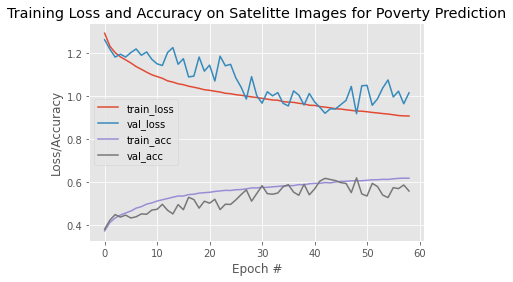

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Satelitte Images for Poverty Prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
testGen.numImages

5616

In [ ]:
num_pred = (testGen.numImages // 8) * 8
num_pred

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
num_pred = (testGen.numImages // 8) * 8
predictions = model.predict(testGen.generator(passes=1),
                                      steps=testGen.numImages // 8)
y_pred = predictions.argmax(axis=-1)
y_true = test_data['labels'][...].argmax(axis=-1)[:num_pred]
print(classification_report(y_true, y_pred,
                            target_names=classNames))
#predictions = model.predict(testX, batch_size=32)
#print(classification_report(testY.argmax(axis=1),
                            #predictions.argmax(axis=1), target_names=classNames))

[INFO] evaluating network...
                  precision    recall  f1-score   support

    Mali_archive       0.64      0.65      0.64      1475
ethiopia_archive       0.74      0.66      0.70      1717
  malawi_archive       0.56      0.59      0.57      1270
 nigeria_archive       0.53      0.59      0.56      1154

        accuracy                           0.62      5616
       macro avg       0.62      0.62      0.62      5616
    weighted avg       0.63      0.62      0.63      5616



In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
img = cv2.cvtColor(cv2.imread(imagePaths[0]), cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(img)

In [ ]:
categories = []

mali = 0
etho = 0
malawi = 0
nig = 0
for cat in imagePaths:
  category = cat.split('\\')[-3]

  if category == 'Mali_archive':
    mali = mali+1
  elif category == 'ethiopia_archive':
    etho = etho+1
  elif category == 'malawi_archive':
    malawi = malawi+1
  elif category == 'nigeria_archive':
    nig = nig +1

print('Mali image count {}'.format(mali))
print('Etho image count {}'.format(etho))
print('Malawi image count {}'.format(malawi))
print('NIg image count {}'.format(nig))

In [ ]:
imagePaths[:5]

In [ ]:
imagePaths[80].split(os.path.sep)[1]

In [ ]:
def load_data(imagePaths, verbose=1000):
    # initialize the list of features and labels
    data = []
    labels = []
    # loop over the input images
    for (i, imagePath) in enumerate(imagePaths):
        # load the image and extract the class label assuming
        # that our path has the following format:
        # /path/to/dataset/{class}/{image}.jpg
        image = cv2.imread(imagePath)
        image = image.astype('float')/255.0
        label = imagePath.split(os.path.sep)[1]
        # treat our processed image as a "feature vector"
        # by updating the data list followed by the labels
        data.append(image)
        labels.append(label)

      # show an update every `verbose` images
        if (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1,
                                          len(imagePaths)))

    # return a tuple of the data and labels
    return (np.array(data), np.array(labels))


In [ ]:
(data, labels) = load_data(imagePaths[:32], verbose=25000)

In [ ]:
np.unique(labels)

In [ ]:
data.shape

In [ ]:
data.dtype

In [ ]:
data[0:8,:,:,:] = data[0:8,:,:,:].astype('float')

In [ ]:
data[0] = data[0].astype('float')

In [ ]:
data =data/255.0

In [ ]:
data.dtype

In [ ]:
bs = 8

for i in range(0, data.shape[0], bs):
  data[i:i+bs,:,:,:] = data[i:i+bs,:,:,:]/255.0

In [ ]:
data